In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [75]:
train = pd.read_csv('./_data/train.csv', index_col=0)#id를 인덱스로
test = pd.read_csv('./_data/test.csv', index_col=0)

## train.csv : 학습 데이터
* id: 데이터 고유 id
* age: 나이
* sex: 성별 (여자 = 0, 남자 = 1)
* cp: 가슴 통증(chest pain) 종류 
    * 0 : asymptomatic 무증상
    * 1 : atypical angina 일반적이지 않은 협심증
    * 2 : non-anginal pain 협심증이 아닌 통증
    * 3 : typical angina 일반적인 협심증
* trestbps: (resting blood pressure) 휴식 중 혈압(mmHg)
* chol: (serum cholestoral) 혈중 콜레스테롤 (mg/dl)
* fbs: (fasting blood sugar) 공복 중 혈당 (120 mg/dl 이하일 시 = 0, 초과일 시 = 1)
* restecg: (resting electrocardiographic) 휴식 중 심전도 결과 
    * 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
    * 1: 정상
    * 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* thalach: (maximum heart rate achieved) 최대 심박수
* exang: (exercise induced angina) 활동으로 인한  협심증 여부 (없음 = 0, 있음 = 1)
* oldpeak: (ST depression induced by exercise relative to rest) 휴식 대비 운동으로 인한 ST 하강
* slope: (the slope of the peak exercise ST segment) 활동 ST 분절 피크의 기울기
    * 0: downsloping 하강
    * 1: flat 평탄
    * 2: upsloping 상승
* ca: number of major vessels colored by flouroscopy 형광 투시로 확인된 주요 혈관 수 (0~3 개) 
* Null 값은 숫자 4로 인코딩됨 
* thal: thalassemia 지중해빈혈 여부
    * 0 = Null 
    * 1 = normal 정상
    * 2 = fixed defect 고정 결함
    * 3 = reversable defect 가역 결함
* target: 심장 질환 진단 여부
    * 0: < 50% diameter narrowing
    * 1: > 50% diameter narrowing

In [3]:
train.describe() 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,54.496689,0.682119,1.066225,132.033113,244.529801,0.158940,0.509934,150.629139,0.324503,0.976821,1.377483,0.602649,2.317881,0.549669
std,8.904586,0.467202,1.056213,17.909929,56.332206,0.366837,0.514685,23.466463,0.469747,1.085998,0.640226,0.917093,0.604107,0.499183
min,34.000000,0.000000,0.000000,94.000000,131.000000,0.000000,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.500000,0.000000,0.000000,120.000000,208.000000,0.000000,0.000000,136.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,54.000000,1.000000,1.000000,130.000000,239.000000,0.000000,1.000000,155.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,270.000000,0.000000,1.000000,168.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,192.000000,564.000000,1.000000,2.000000,195.000000,1.000000,5.600000,2.000000,3.000000,3.000000,1.000000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 1 to 151
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       151 non-null    int64  
 1   sex       151 non-null    int64  
 2   cp        151 non-null    int64  
 3   trestbps  151 non-null    int64  
 4   chol      151 non-null    int64  
 5   fbs       151 non-null    int64  
 6   restecg   151 non-null    int64  
 7   thalach   151 non-null    int64  
 8   exang     151 non-null    int64  
 9   oldpeak   151 non-null    float64
 10  slope     151 non-null    int64  
 11  ca        151 non-null    int64  
 12  thal      151 non-null    int64  
 13  target    151 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 17.7 KB


### 여성과 남성으로 나누어 살펴보기

In [5]:
woman_target = train.loc[train['sex']==0,'target']
man_target = train.loc[train['sex']==1,'target']


**sns.set_style()**
* default : `darkgrid`
* options : `darkgrid`, `whitegrid`, `dark`, `white`, `ticks`

**sns.despine()**
* default : `top=True`,`right=True`
* options: `left`, `right`, `top`, `bottom`

**sns.set_context()**
* 표 스케일 조정 paper < notebook< talk < poster
* options : `paper`, `notebook`, `talk`, `poster`, `font_scale = .5`, `rc={grid.linewidth":5}`

* rc params
```
{'axes.labelsize': 17.6,
 'axes.titlesize': 19.200000000000003,
 'font.size': 19.200000000000003,
 'grid.linewidth': 1.6,
 'legend.fontsize': 16.0,
 'lines.linewidth': 2.8000000000000003,
 'lines.markeredgewidth': 0.0,
 'lines.markersize': 11.200000000000001,
 'patch.linewidth': 0.48,
 'xtick.labelsize': 16.0,
 'xtick.major.pad': 11.200000000000001,
 'xtick.major.width': 1.6,
 'xtick.minor.width': 0.8,
 'ytick.labelsize': 16.0,
 'ytick.major.pad': 11.200000000000001,
 'ytick.major.width': 1.6,
 'ytick.minor.width': 0.8}
 ```

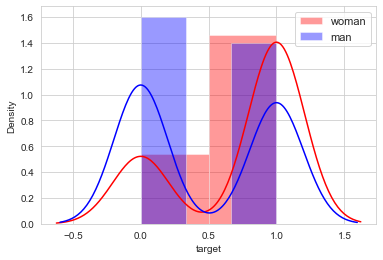

In [6]:
sns.set_style('whitegrid')   
sns.distplot(woman_target, kde=True, color='red', label= 'woman')
sns.distplot(man_target, kde=True, color='blue', label= 'man')
sns.set_context('notebook')
plt.legend()
plt.show()

* 여성 환자 비율이 높음

In [7]:
woman = train.loc[train['sex']==0]
man = train.loc[train['sex']==1]

In [8]:
woman.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,48.000000,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.00000,48.000000,48.000000,48.000000
mean,55.708333,0.0,1.083333,134.333333,266.041667,0.145833,0.541667,150.979167,0.250000,0.752083,1.43750,0.458333,2.104167,0.729167
std,8.225436,0.0,0.963887,19.055723,76.069945,0.356674,0.544150,21.234746,0.437595,0.933306,0.54211,0.849489,0.472187,0.449093
min,35.000000,0.0,0.000000,100.000000,141.000000,0.000000,0.000000,96.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,51.000000,0.0,0.000000,120.000000,213.250000,0.000000,0.000000,142.000000,0.000000,0.000000,1.00000,0.000000,2.000000,0.000000
50%,56.000000,0.0,1.000000,133.000000,263.500000,0.000000,1.000000,157.000000,0.000000,0.450000,1.00000,0.000000,2.000000,1.000000
75%,63.000000,0.0,2.000000,140.500000,305.250000,0.000000,1.000000,165.250000,0.250000,1.250000,2.00000,1.000000,2.000000,1.000000
max,71.000000,0.0,3.000000,180.000000,564.000000,1.000000,2.000000,182.000000,1.000000,4.000000,2.00000,3.000000,3.000000,1.000000


In [9]:
woman[woman['target']==1].shape

(35, 14)

In [10]:
man.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,103.000000,103.0,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,53.932039,1.0,1.058252,130.961165,234.504854,0.165049,0.495146,150.466019,0.359223,1.081553,1.349515,0.669903,2.417476,0.466019
std,9.187867,0.0,1.101027,17.341960,40.999970,0.373040,0.502421,24.534815,0.482119,1.139380,0.681819,0.943381,0.634379,0.501283
min,34.000000,1.0,0.000000,94.000000,131.000000,0.000000,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,47.500000,1.0,0.000000,120.000000,206.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,54.000000,1.0,1.000000,130.000000,233.000000,0.000000,0.000000,154.000000,0.000000,0.800000,1.000000,0.000000,2.000000,0.000000
75%,60.000000,1.0,2.000000,140.000000,258.000000,0.000000,1.000000,169.500000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.0,3.000000,192.000000,330.000000,1.000000,1.000000,195.000000,1.000000,5.600000,2.000000,3.000000,3.000000,1.000000


In [11]:
man[man['target']==1].shape

(48, 14)

전체 (83/151)
여성(35/48) 남성(48/103)

In [14]:
target = train.loc[train['target']==1]
nontarget = train.loc[train['target']==0]

In [15]:
target.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.0
mean,52.506024,0.578313,1.481928,130.048193,246.409639,0.180723,0.518072,158.361446,0.156627,0.563855,1.554217,0.216867,2.084337,1.0
std,9.012692,0.496831,0.941735,16.345286,62.035009,0.387128,0.502711,19.949680,0.365658,0.735275,0.629615,0.605829,0.498897,0.0
min,34.000000,0.000000,0.000000,94.000000,141.000000,0.000000,0.000000,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,45.000000,0.000000,1.000000,120.000000,210.000000,0.000000,0.000000,149.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.0
50%,53.000000,1.000000,2.000000,130.000000,236.000000,0.000000,1.000000,162.000000,0.000000,0.200000,2.000000,0.000000,2.000000,1.0
75%,58.500000,1.000000,2.000000,139.000000,270.000000,0.000000,1.000000,173.000000,0.000000,1.000000,2.000000,0.000000,2.000000,1.0
max,71.000000,1.000000,3.000000,180.000000,564.000000,1.000000,1.000000,194.000000,1.000000,3.500000,2.000000,3.000000,3.000000,1.0


In [16]:
nontarget.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.0
mean,56.926471,0.808824,0.558824,134.455882,242.235294,0.132353,0.500000,141.191176,0.529412,1.480882,1.161765,1.073529,2.602941,0.0
std,8.197772,0.396151,0.967877,19.501576,48.834511,0.341394,0.532524,24.109983,0.502845,1.228670,0.588707,1.012108,0.601979,0.0
min,35.000000,0.000000,0.000000,108.000000,131.000000,0.000000,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
25%,52.000000,1.000000,0.000000,120.000000,206.000000,0.000000,0.000000,126.000000,0.000000,0.575000,1.000000,0.000000,2.000000,0.0
50%,58.000000,1.000000,0.000000,130.000000,242.500000,0.000000,0.000000,142.500000,1.000000,1.200000,1.000000,1.000000,3.000000,0.0
75%,62.250000,1.000000,1.000000,144.250000,270.250000,0.000000,1.000000,161.000000,1.000000,2.450000,2.000000,2.000000,3.000000,0.0
max,77.000000,1.000000,3.000000,192.000000,407.000000,1.000000,2.000000,195.000000,1.000000,5.600000,2.000000,3.000000,3.000000,0.0


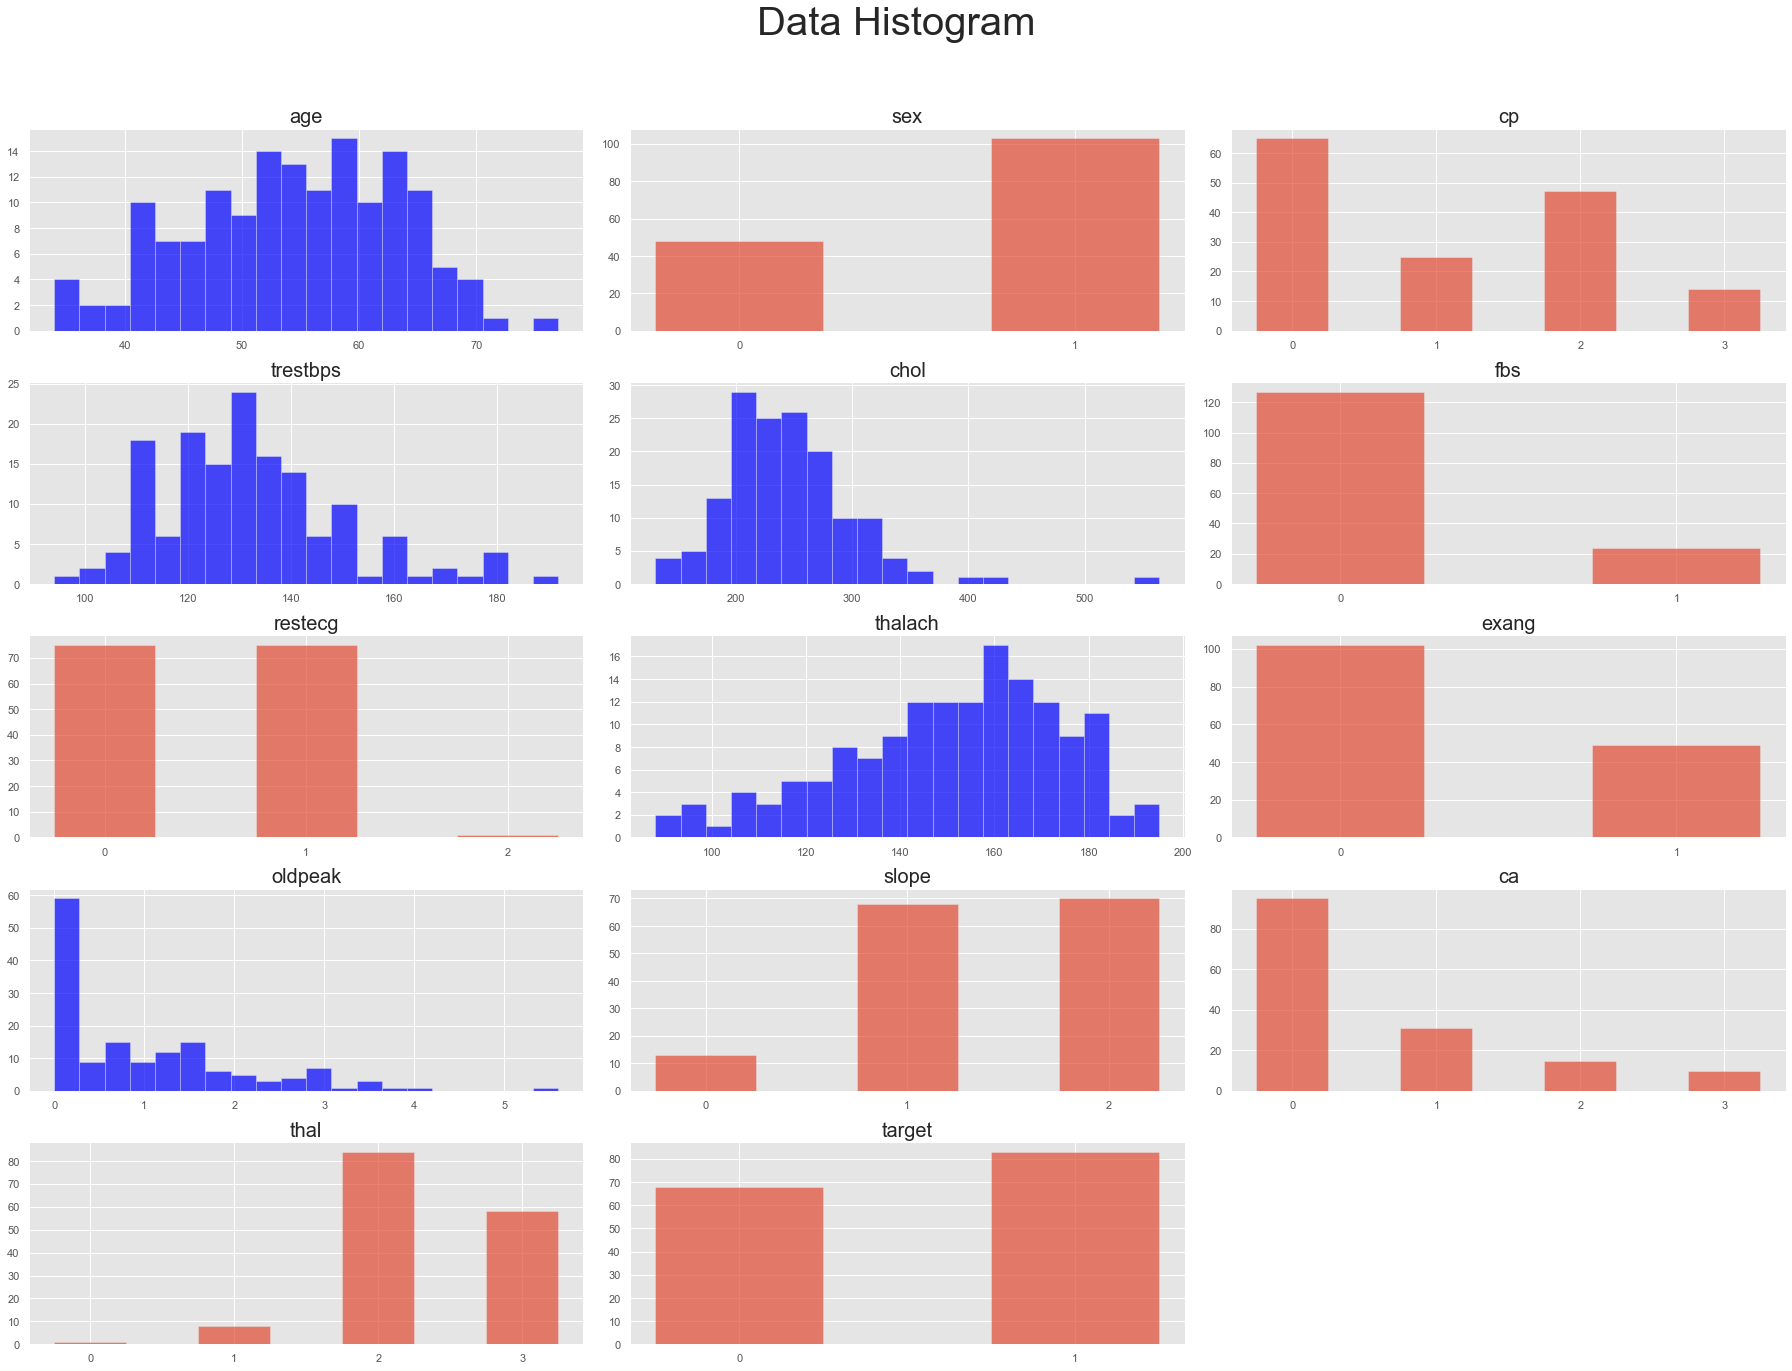

In [17]:
plt.style.use("ggplot")

# 히스토그램 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,20))
plt.suptitle("Data Histogram", fontsize=40)

cols = train.columns
for i in range(len(cols)):
    plt.subplot(5,3,i+1)
    plt.title(cols[i], fontsize=20)
    if len(train[cols[i]].unique()) > 20:
        plt.hist(train[cols[i]], bins=20, color='b', alpha=0.7)
    else:
        temp = train[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

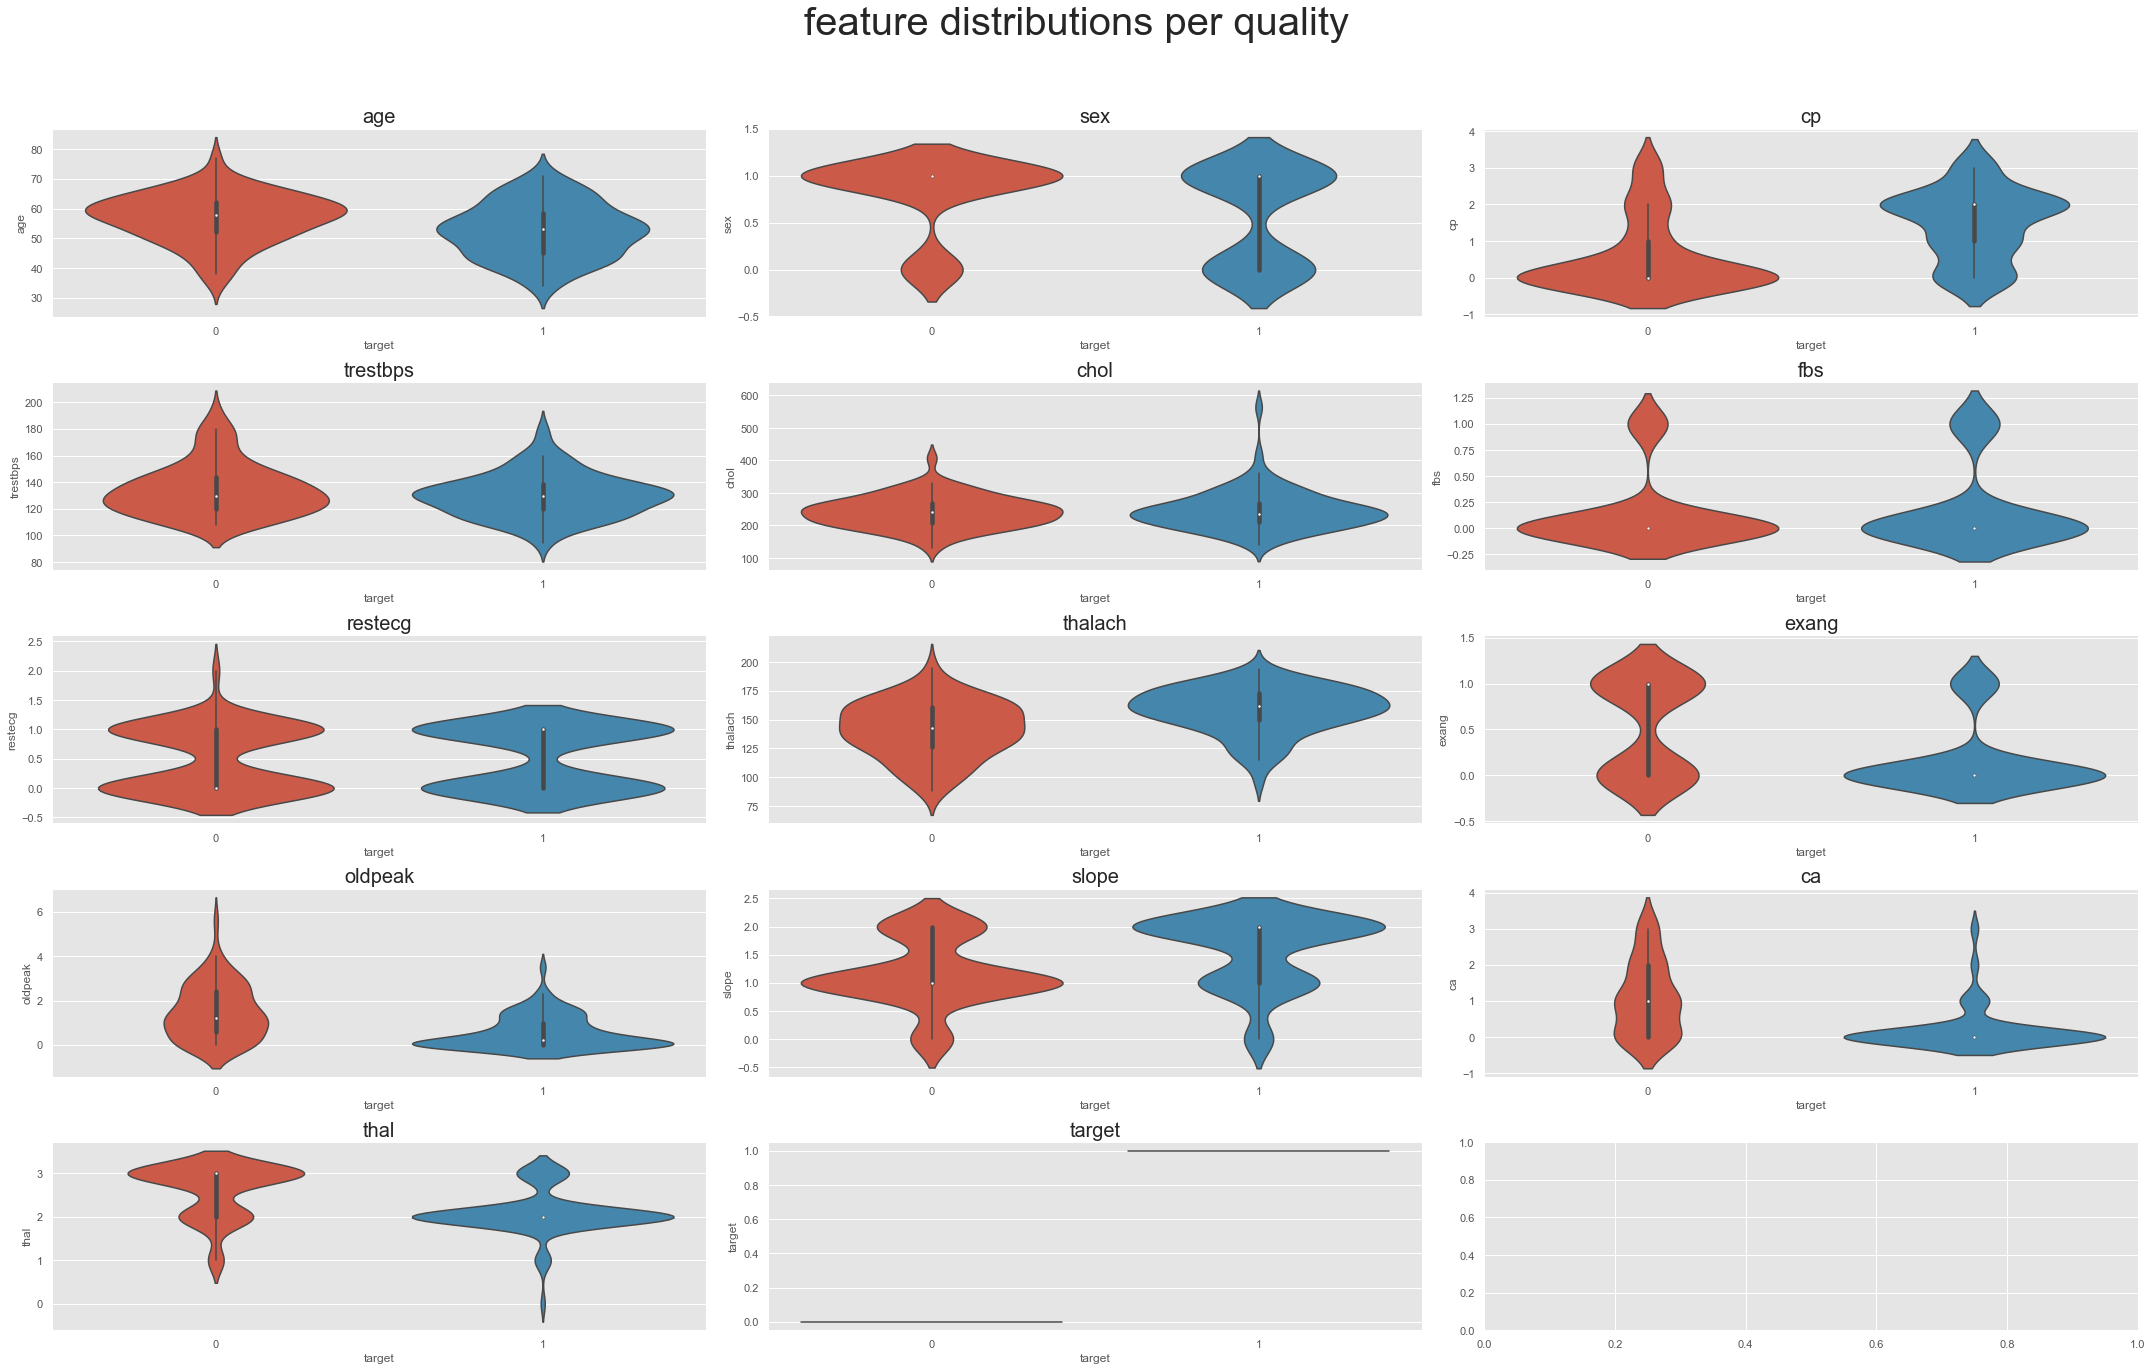

In [18]:
fig, axes = plt.subplots(5, 3, figsize=(30, 20))

fig.suptitle('feature distributions per quality', fontsize= 40)
for ax, col in zip(axes.flat, train.columns):
    sns.violinplot(x= 'target', y= col, ax=ax, data=train)
    ax.set_title(col, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* age: 60대의 비율이 높음
* sex: 비환자인 남성 비율이 높음


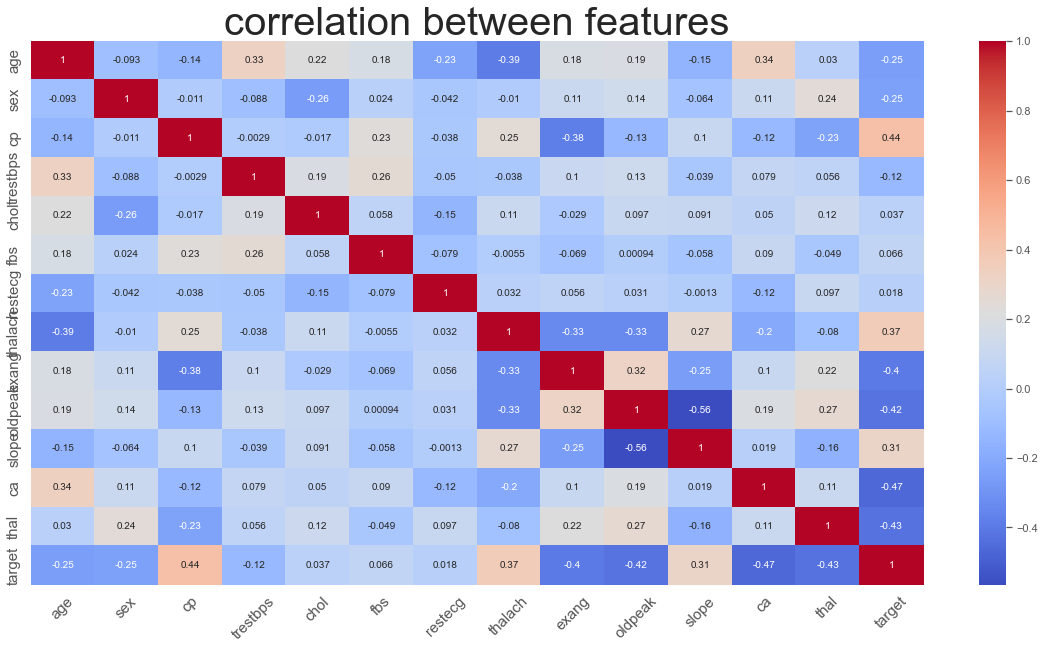

In [19]:
plt.figure(figsize=(20,10))

heat_table = train.corr()
heatmap_ax = sns.heatmap(heat_table, annot=True, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()

* 0.33, 0.44..  상관관계가 두드러지는 feature는 없는 것으로 보임

In [102]:
y_train = train.pop('target')
y_train = y_train.to_numpy()
x_train = train.to_numpy()

In [103]:
x_test = test.to_numpy()

In [104]:
import tensorflow as tf
import autokeras as ak
ak_model = ak.StructuredDataClassifier(
    overwrite=True, max_trials=2, loss='binary_crossentropy'
)
ak_model.fit(x_train, y_train, epochs=80, validation_split=0.3, )

Trial 2 Complete [00h 00m 04s]
val_accuracy: 0.8260869383811951

Best val_accuracy So Far: 0.8260869383811951
Total elapsed time: 00h 00m 09s
INFO:tensorflow:Oracle triggered exit
Epoch 1/80
5/5 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5762
Epoch 2/80
5/5 [==============================] - 0s 2ms/step - loss: 0.6535 - accuracy: 0.6424
Epoch 3/80
5/5 [==============================] - 0s 2ms/step - loss: 0.6202 - accuracy: 0.6821
Epoch 4/80
5/5 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.7020
Epoch 5/80
5/5 [==============================] - 0s 1ms/step - loss: 0.5634 - accuracy: 0.7417
Epoch 6/80
5/5 [==============================] - 0s 1ms/step - loss: 0.5390 - accuracy: 0.7815
Epoch 7/80
5/5 [==============================] - 0s 2ms/step - loss: 0.5167 - accuracy: 0.7881
Epoch 8/80
5/5 [==============================] - 0s 1ms/step - loss: 0.4957 - accuracy: 0.8079
Epoch 9/80
5/5 [==============================] - 0s

In [105]:
predict_y = ak_model.predict(x_test)

5/5 [==============================] - 0s 1ms/step


In [106]:
predict_y

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],

In [107]:
submission = pd.read_csv('./_data/sample_submission.csv')

In [108]:
submission['target']=predict_y

In [101]:
submission.to_csv('./submission.csv', index=False)

# score 0.8358208955